# Code to generate SDPD and Dynamic MESS given parameters, a weight matrix, and a list of historical data 

### Import packages and code the functions

In [1]:
import numpy as np
import pandas as pd
import math
from scipy.linalg import expm, sinm, cosm
from numpy.linalg import matrix_power

In [2]:
def dim_matrix(matrix):
    return len(matrix),len(matrix[0])

In [3]:
def sum_matrix_list(mat_list):
    length = len(mat_list)
    running_sum = mat_list[0]
    
    for r in range(1, length):
        running_sum = running_sum + mat_list[r]
        
    return running_sum

In [4]:
def diag_to_matrix(array):
    length = len(array)
    matrix = np.zeros([length,length])

    for row in range(0, length):
        matrix[row][row] = array[row]

    return matrix

In [5]:
#Note: hist_Y must be a list, such as [no.zeros([15,1])]
def generate_sdpd(weight_matrix, rho, phi, lam, total_time, hist_Y):
    
    length = len(weight_matrix)
    hist_length = len(hist_Y)
    
    id_matrix = diag_to_matrix(length*[1])
    s_matrix = id_matrix- lam * weight_matrix

    for time_period in range(0,total_time):
        aux_matrix = rho*id_matrix + phi*weight_matrix
        errors = np.random.normal(0,1,length).reshape(length,1)

        new_y = np.dot( np.linalg.inv(s_matrix),  np.dot(aux_matrix,hist_Y[-1])) + errors
        hist_Y.append(new_y)
        
    return hist_Y[hist_length:]

In [6]:
#Note: hist_Y must be a list, such as [no.zeros([15,1])]
def generate_mesds(weight_matrix, alpha, phi, pi, total_time, hist_Y):
    length = len(weight_matrix)
    
    hist_length = len(hist_Y)
    init_hist_length = len(hist_Y)


    id_matrix = diag_to_matrix(length*[1])
    aux_matrix = phi*id_matrix + pi*weight_matrix

    exp_weight = expm(alpha*weight_matrix)
    inv_exp_weight = expm(-alpha*weight_matrix)

    state_list = [ np.dot(matrix_power(aux_matrix,hist_length-h),Y)/float(math.factorial(hist_length-h))  for Y,h in zip(hist_Y,range(0,hist_length)) ]

    for r in range(0,total_time):
        errors =  errors = np.random.normal(0,1,length).reshape(length,1)
        spatial_errors = np.dot(inv_exp_weight,errors)

        state_sum = sum_matrix_list(state_list)
        new_Y = -state_sum + spatial_errors

        hist_Y.append(new_Y)
        hist_length = len(hist_Y)

        state_list = [np.dot(aux_matrix,Y)/float(hist_length-h) for Y,h in zip(hist_Y,range(0,hist_length)) ]
        
    return hist_Y[init_hist_length:]

In [7]:
#Note: hist_Y must be a list, such as [no.zeros([15,1])]
def forecast_mesds(weight_matrix, alpha, phi, pi, total_time, hist_Y):
    length = len(weight_matrix)
    
    hist_length = len(hist_Y)
    init_hist_length = len(hist_Y)


    id_matrix = diag_to_matrix(length*[1])
    aux_matrix = phi*id_matrix + pi*weight_matrix

    exp_weight = expm(alpha*weight_matrix)
    inv_exp_weight = expm(-alpha*weight_matrix)

    state_list = [ np.dot(matrix_power(aux_matrix,hist_length-h),Y)/float(math.factorial(hist_length-h))  for Y,h in zip(hist_Y,range(0,hist_length)) ]

    for r in range(0,total_time):
        spatial_errors = np.zeros([length,1])

        state_sum = sum_matrix_list(state_list)
        new_Y = -state_sum + spatial_errors

        hist_Y.append(new_Y)
        hist_length = len(hist_Y)

        state_list = [np.dot(aux_matrix,Y)/float(hist_length-h) for Y,h in zip(hist_Y,range(0,hist_length)) ]
        
    return hist_Y[init_hist_length:]

In [8]:
#Note: hist_Y must be a list, such as [no.zeros([15,1])]
def forecast_sdpd(weight_matrix, rho, phi, lam, total_time, hist_Y):
    
    length = len(weight_matrix)
    hist_length = len(hist_Y)
    
    id_matrix = diag_to_matrix(length*[1])
    s_matrix = id_matrix- lam * weight_matrix

    for time_period in range(0,total_time):
        aux_matrix = rho*id_matrix + phi*weight_matrix
        errors = np.zeros([length,1])

        new_y = np.dot( np.linalg.inv(s_matrix),  np.dot(aux_matrix,hist_Y[-1])) + errors
        hist_Y.append(new_y)
        
    return hist_Y[hist_length:]

## Test run, randomly generates a 7 x 7 weight matrix to consider sample paths

In [9]:
#Test Weight Matrix
test_length = 7

row = list(np.random.uniform(0,.1,test_length) ) 
row[0] = 1

weight_matrix = np.array(row)
for r in range(1,test_length):
    row = list(np.random.uniform(0,.2,test_length) ) 
    row[r-1] = 1
    weight_matrix = np.vstack( [weight_matrix, row])

In [10]:
generate_sdpd(weight_matrix, .6, .1, .05, 2, [np.zeros([test_length,1]) ] )

[array([[-0.45507964],
        [ 0.22247293],
        [ 1.18376944],
        [-0.22614661],
        [ 0.16736352],
        [-0.48495066],
        [ 0.40179203]]),
 array([[-1.89676586],
        [-1.2270765 ],
        [ 1.12213496],
        [-0.38652899],
        [-1.9865956 ],
        [-1.00727364],
        [-0.01304522]])]

In [11]:
generate_mesds(weight_matrix,10,.2,.1, 2, [np.zeros([test_length,1])])

[array([[ -13.95067531],
        [-124.04526277],
        [ 134.08133871],
        [-157.16647944],
        [ 198.46022802],
        [-302.56288064],
        [ 553.24572018]]),
 array([[  18.40738068],
        [ 162.31699841],
        [-165.94193276],
        [ 194.05401868],
        [-268.09502401],
        [ 437.66858786],
        [-768.60536345]])]

# Plot the samples across time

### Data From a SDPD

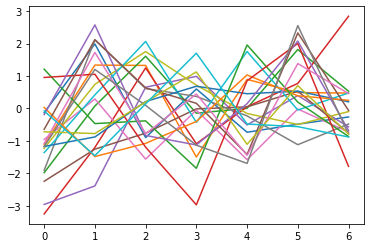

In [12]:
dynamic_spatial_data = generate_sdpd(weight_matrix, .6 ,.2,.2, 20, [np.zeros([test_length,1])])
data_df = pd.DataFrame(np.concatenate( dynamic_spatial_data, axis=1 ))

data_df.plot(legend = None)

#### Forecast the next 5 periods for this data

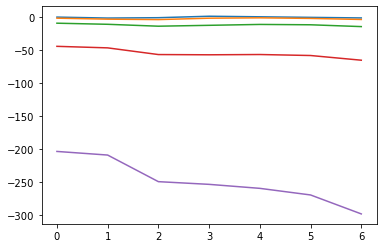

In [13]:
forecast_data = forecast_sdpd( weight_matrix,1,.2,.5, 5, dynamic_spatial_data )
forecast_df = pd.DataFrame(np.concatenate( forecast_data, axis=1 )).plot(legend = None)

### Data from dynamic MESS

In [14]:
dynamic_spatial_data = generate_mesds(weight_matrix,1,.2,.5, 20, [np.zeros([test_length,1])])
data_df = pd.DataFrame(np.concatenate( dynamic_spatial_data, axis=1 ))

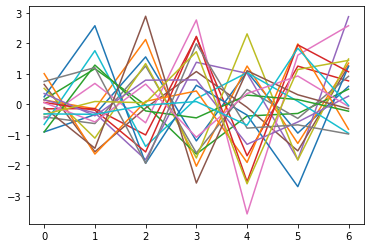

In [15]:
data_df.plot(legend = None )

#### Forecasts the next 5 periods for each series

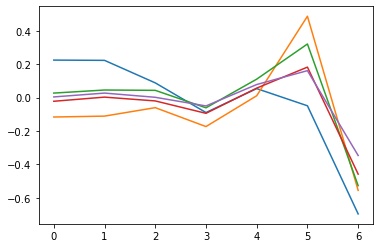

In [16]:
forecast_data = forecast_mesds( weight_matrix,1,.2,.5, 5, dynamic_spatial_data )
forecast_df = pd.DataFrame(np.concatenate( forecast_data, axis=1 )).plot(legend = None)